In [ ]:
# uncomment on Colab
#!pip install datasets sklearn torchinfo

In [2]:
import torch

from datasets import load_dataset
from torchinfo import summary
from transformers import AutoConfig, AutoModel, AutoTokenizer

In [3]:
wikitext = load_dataset("wikitext", "wikitext-103-v1", split="all")
imdb = load_dataset("stanfordnlp/imdb", split="all")
print(imdb[0]["text"])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [7]:
MODEL_ID = "albert-large-v2"  # "bert-large-uncased" # "albert-large-v2"
NUM_ATTN_HEADS = 16
tokeniser = AutoTokenizer.from_pretrained(MODEL_ID)
config = AutoConfig.from_pretrained(MODEL_ID)
config.num_attention_heads = NUM_ATTN_HEADS
model = AutoModel.from_pretrained(MODEL_ID, config=config, attn_implementation="eager")
print(model.config)

AlbertConfig {
  "_name_or_path": "albert-large-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 16,
  "num_hidden_groups": 1,
  "num_hidden_layers": 24,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.1",
  "type_vocab_size": 2,
  "vocab_size": 30000
}



In [5]:
# note that the same single layer is called repeatedly in ALBERT
print(summary(model, depth=8))

Layer (type:depth-idx)                                  Param #
AlbertModel                                             --
├─AlbertEmbeddings: 1-1                                 --
│    └─Embedding: 2-1                                   3,840,000
│    └─Embedding: 2-2                                   65,536
│    └─Embedding: 2-3                                   256
│    └─LayerNorm: 2-4                                   256
│    └─Dropout: 2-5                                     --
├─AlbertTransformer: 1-2                                --
│    └─Linear: 2-6                                      132,096
│    └─ModuleList: 2-7                                  --
│    │    └─AlbertLayerGroup: 3-1                       --
│    │    │    └─ModuleList: 4-1                        --
│    │    │    │    └─AlbertLayer: 5-1                  --
│    │    │    │    │    └─LayerNorm: 6-1               2,048
│    │    │    │    │    └─AlbertAttention: 6-2         --
│    │    │    │    │    │    

In [6]:
input = tokeniser("The pizza Hawaii tasted great, so I knew it was a good choice.", return_tensors="pt", truncation=True, return_attention_mask=False)
output = model(**input, output_hidden_states=True, output_attentions=True)

In [7]:
tokeniser.decode(input["input_ids"][0])

'[CLS] the pizza hawaii tasted great, so i knew it was a good choice.[SEP]'

In [8]:
output.attentions[0].shape

torch.Size([1, 16, 17, 17])

In [51]:
model.embeddings(**input).shape

torch.Size([1, 17, 128])

In [52]:
model

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(30000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=1024, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False

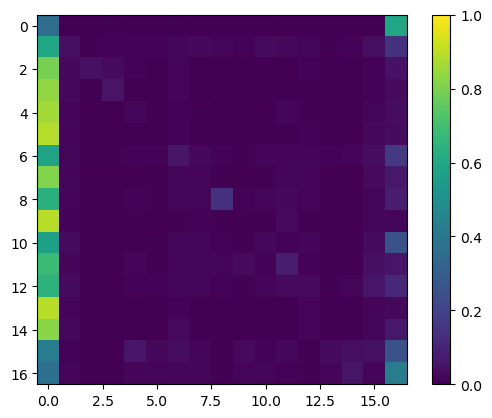

In [29]:
import matplotlib.pyplot as plt
layer = 0
head = 0
plt.imshow(output.attentions[layer].squeeze()[head].detach(),  vmin=0, vmax=1)
plt.colorbar()